In [149]:
import sys
sys.path.append('../')

from nonlinear_system.ct_system import ContinuousTimeSystem
from nonlinear_system.epidem_odes import UIV
from moving_gauss import GaussEstimator
import numpy as np
import matplotlib.pyplot as plt
import math
from numpy.polynomial import Polynomial as Pol

In [150]:
verbose = False
verbose_lagrange = False

sampling_dt = 1
integration_per_sample = 100
integration_dt = sampling_dt/integration_per_sample
num_sampling_steps = 30
num_integration_steps = num_sampling_steps*integration_per_sample

uiv_ode = UIV(beta=1, p=2)
params = {}
params["beta"] = uiv_ode.beta
params["p"] = uiv_ode.p_p
params["c"] = uiv_ode.c
params['delta'] = uiv_ode.delta

In [151]:
n = uiv_ode.n
m = uiv_ode.m
p = uiv_ode.p

U0 = 4
V0 = 50e-8
# x0 = [U0, 0, 0]
x0 = [U0, 0, V0]

nderivs = uiv_ode.nderivs

N = 6           # Number of samples in a window
n_gauss = 5     # Number of Gaussian Functions

Yd = 0.5
delta_s = 1

delay = 1
infection_step = 0  # default is 0
estimator = GaussEstimator(n_gauss, N, sampling_dt)

eval_time = (N-1-delay)*sampling_dt  # (N-1)*sampling_dt

In [152]:
def deriv_bound_gauss(k, d, M, delta_s=delta_s):
    if k==0:
        return 0.25*np.power(delta_s, d+1)*M/(d+1)
    return np.power(delta_s, d-k+1)*M*math.comb(d, k-1)

In [153]:
def generate_lagrange(d, N=N, sampling_dt=sampling_dt):
    '''
    Generate lagrange polynomial to estimate dth derivative error
    '''
    num_t_points = d + 1 # number of points for the residual polynomial
    window_times = np.linspace(0., N*sampling_dt, N, endpoint=False)
    l_indices = np.arange(N-1-d, N, 1) # indices of the window which we pick for D
    l_times = window_times[l_indices] # times corresponding to D (s0, ..., sd)
    lagrange_pols = []
    for i in range(num_t_points):
        # build the lagrange polynomial, which is zero at all evaluation samples except one
        evals = np.zeros(num_t_points)
        evals[i] = 1.0  # we are choosing the data points that are closest to our evaluation point
        l_i = Pol.fit(l_times, evals, d)
        lagrange_pols.append(l_i)

        # to checking that you built the right lagrange polynomial, evaluate it at the relevant points
        if verbose_lagrange:
            for j in range(num_t_points):
                print(f't = {l_times[j]:.3f}, l_{i}(t) = {l_i(l_times[j])}')

        # t = np.linspace(l_times[0], l_times[-1], (l_indices[-1]-l_indices[0])*num_integration_steps)
        # for i in range(num_t_points):            ## Plotting Lagrange Polynomials
        #     plt.plot(t, lagrange_pols[i](t))
        # plt.grid()
        # plt.show()
                
    return lagrange_pols, l_indices

In [154]:
lagrange_pols_d1, l_indices_d1 = generate_lagrange(d=1)
lagrange_pols_d2, l_indices_d2 = generate_lagrange(d=2)

x = np.zeros((n, num_integration_steps))
y_d = np.zeros((nderivs, num_integration_steps))
x_hat = np.zeros((n, num_integration_steps))
x2_hat = np.zeros((n, num_integration_steps))
y_hat = np.zeros((nderivs, num_integration_steps))
x2_bound = np.zeros((nderivs, num_integration_steps))
y_bound = np.zeros((nderivs, num_integration_steps))

y_samples = np.zeros((nderivs, num_sampling_steps))
y_hat_samples = np.zeros((nderivs, num_sampling_steps))
x_samples = np.zeros((n, num_sampling_steps))
x_hat_samples = np.zeros((n, num_sampling_steps))
x2_hat_samples = np.zeros((n, num_sampling_steps))

theta = np.empty((n_gauss, num_sampling_steps)) # coefficients of fitted polynomial

integration_time = np.zeros((num_integration_steps,))
sampling_time = np.zeros((num_sampling_steps,))

x[:, 0] = x0
x_samples[:, 0] = x0

sys = ContinuousTimeSystem(uiv_ode, x0=x0, dt=integration_dt)

y_d[:, 0] = sys.y
y_samples[:, 0] = sys.y

In [155]:
if verbose:
    print(f"delay = {delay}")
for t in range(0, num_sampling_steps):

    # if t==infection_step:
    #     sys.reset(x0= [U0, 0, V0],t=sys.t)

    for i in range(integration_per_sample):
        idx = t*integration_per_sample + i
        x[:, idx], y_d[:, idx] = sys.step(0)
        integration_time[idx] = sys.t
    
    sampling_time[t] = sys.t
    y_samples[:,t] = sys.y
    x_samples[:,t] = sys.x

    if t >= N-1:
        # fit gaussian to N samples at times {t-N+1, ..., t}
        # time coordinates will be {0, ..., N-1}
        theta[:, t] = estimator.fit(y_samples[0, t-N+1:t+1])    # store gaussian coefficients

        res_pol_d1 = 0*lagrange_pols_d1[0]
        for i,res in enumerate(estimator.residuals[l_indices_d1]):
            res_pol_d1 += res*lagrange_pols_d1[i]

        res_pol_d2 = 0*lagrange_pols_d2[0]
        for i,res in enumerate(estimator.residuals[l_indices_d2]):
            res_pol_d2 += res*lagrange_pols_d2[i]

        # estimate with gaussian derivatives with delay (delay samples before last = N-1-delay)
        for j in range(nderivs):
            y_hat_samples[j, t-delay] = estimator.differentiate((N-1-delay)*sampling_dt, j)[0]

        for i in range(integration_per_sample):
            idx = (t-delay)*integration_per_sample + i
            eval_time = (N-delay-2)*sampling_dt+i*integration_dt
            for j in range(nderivs):
                y_hat[j, idx] = estimator.differentiate(eval_time, j)[0]
            x_hat[:, idx] = uiv_ode.invert_output(t=t-delay, y_d=y_hat[:, idx])
            x2_hat[:, idx] = uiv_ode.invert_output2(t=t-delay, y_d=y_hat[:, idx])
        
        # Calculate upper bound for G within the window
        t_window = np.linspace(N-delay-2, N-delay-1, integration_per_sample, endpoint=False)*sampling_dt
        
        for i in range(integration_per_sample):
            idx = (t-delay)*integration_per_sample + i
            eval_time = (N-delay-2)*sampling_dt+i*integration_dt
            for j in range(nderivs):
                if j==2:
                    G = np.max(np.abs(estimator.differentiate(t_window, 3)))
                    # Yd = np.max(np.gradient(y_d[2,:], integration_dt)[(t-delay)*integration_per_sample-1:(t-delay+1)*integration_per_sample-1])
                    y_bound[j, idx] = np.abs(res_pol_d2.deriv(j)(eval_time))+deriv_bound_gauss(k=j, d=2, M=Yd+G)
                else:
                    G = np.max(np.abs(estimator.differentiate(t_window, 2)))
                    # Yd = np.max(np.gradient(y_d[1,:], integration_dt)[(t-delay)*integration_per_sample-1:(t-delay+1)*integration_per_sample-1])
                    y_bound[j, idx] = np.abs(res_pol_d1.deriv(j)(eval_time))+deriv_bound_gauss(k=j, d=1, M=Yd+G)
            x2_bound[0, idx] = y_bound[0, idx]
            x2_bound[1, idx] = (y_bound[1,idx]+params['c']*y_bound[0,idx])/params['p']
            x2_bound[2, idx] = (y_bound[2,idx] + (params['c']+params['delta'])*y_bound[1,idx] + params['c']*params['delta']*y_bound[0,idx]) / (params['p']*params['beta'])

        x_hat_samples[:, t-delay] = uiv_ode.invert_output(t=t-delay, y_d=y_hat_samples[:, t-delay])
        x2_hat_samples[:, t-delay] = uiv_ode.invert_output2(t=t-delay, y_d=y_hat_samples[:, t-delay])
        
        if verbose:
            print(f"On day {t} we estimate day {t-delay}")

    else:
        theta[:, t] = 0.0
        y_hat_samples[:, t] = 0.0
        # x_hat[0, t] = U0


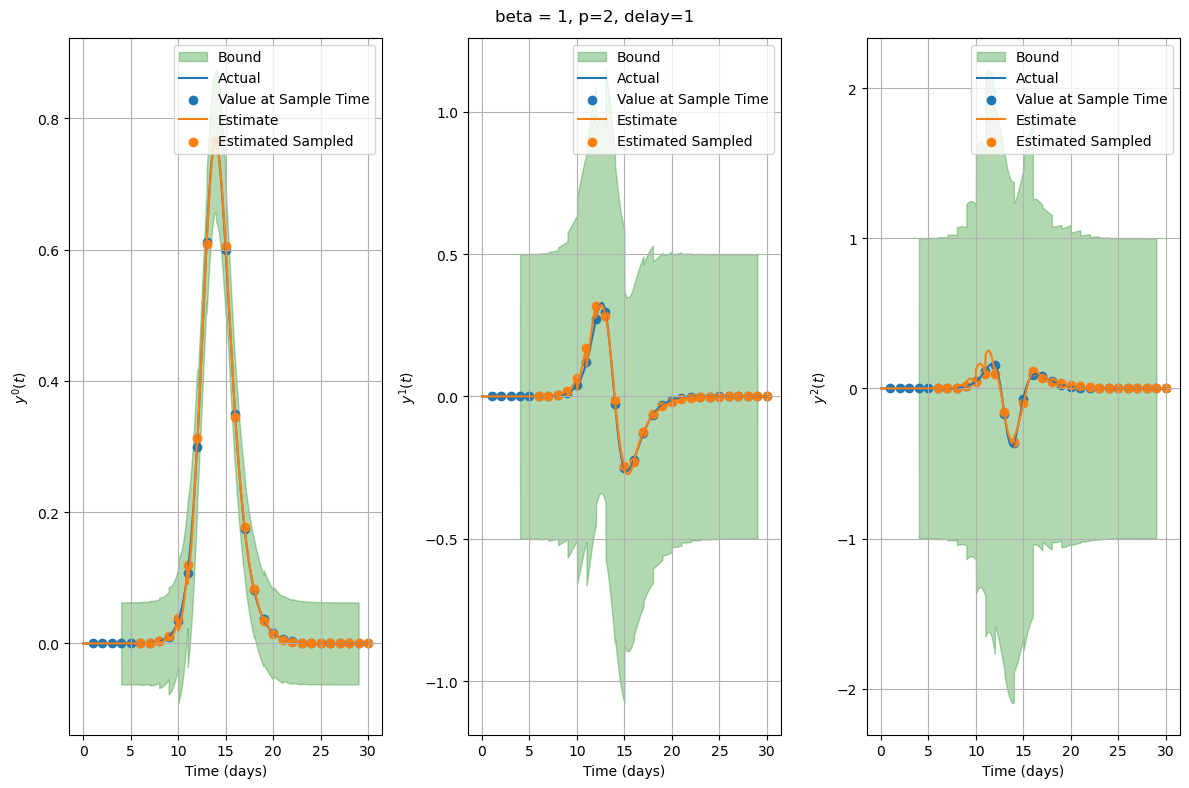

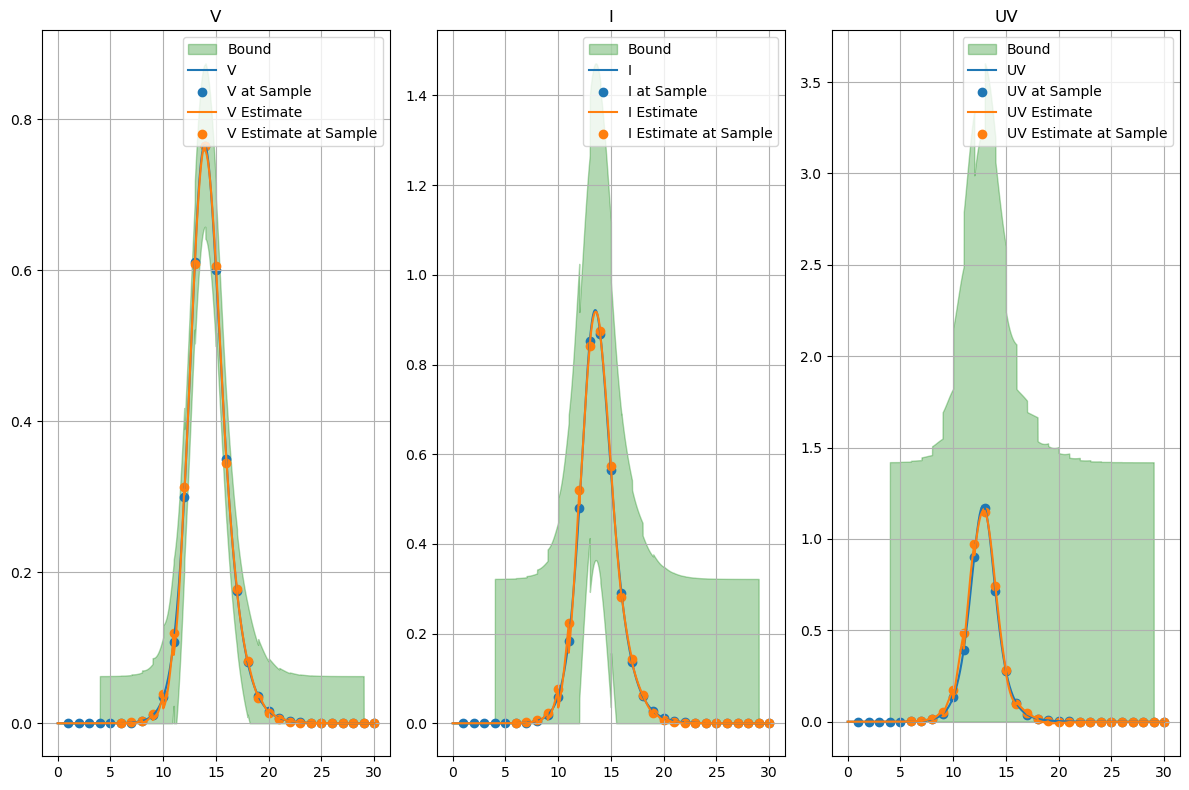

In [156]:

states = ["U", "I", "V"]
states2 = ["V", "I", "UV"]

x2 = UIV.state_transform(x)
x2_samples = UIV.state_transform(x_samples)

# f1 = plt.figure("State Evolution", figsize=(12,8))
# for i in range(n):
#     ax = f1.add_subplot(1,n,i+1)
#     ax.plot(integration_time, x[i,:], label=states[i])
#     ax.scatter(sampling_time, x_samples[i,:], label=states[i]+" at Sample")
#     ax.plot(integration_time, x_hat[i,:], label=states[i]+" Estimate")
#     ax.scatter(sampling_time[N-1:], x_hat_samples[i, N-1:], label=states[i]+" Sampled Estimate")
#     ax.grid()
#     ax.legend()
# f1.suptitle(f"beta = {params['beta']}, p={params['p']}, delay={delay}")
# f1.tight_layout()

f2 = plt.figure("Output Derivatives", figsize=(12,8))
for derivs in range(nderivs):
    ax2 = f2.add_subplot(1, nderivs, derivs+1)
    ax2.fill_between(integration_time, y_hat[derivs,:]-y_bound[derivs,:], y_hat[derivs,:]+y_bound[derivs,:], alpha=0.3, color='green', label='Bound')
    ax2.plot(integration_time, y_d[derivs,:], label="Actual")
    ax2.scatter(sampling_time, y_samples[derivs,:], label="Value at Sample Time")
    ax2.plot(integration_time, y_hat[derivs,:], label="Estimate")
    ax2.scatter(sampling_time[N-1:], y_hat_samples[derivs, N-1:], label="Estimated Sampled")
    ax2.grid()
    ax2.set_xlabel("Time (days)")
    ax2.set_ylabel(f"$y^{derivs}(t)$")
    ax2.legend()
f2.suptitle(f"beta = {params['beta']}, p={params['p']}, delay={delay}")
f2.tight_layout()

f3 = plt.figure("Transformed State Evolution", figsize=(12,8))
for i in range(n):
    ax = f3.add_subplot(1,n,i+1)
    ax.fill_between(integration_time, np.maximum(0, x2_hat[i,:]-x2_bound[i,:]), x2_hat[i,:]+x2_bound[i,:], alpha=0.3, color='green', label='Bound')
    ax.plot(integration_time, x2[i,:], label=states2[i])
    ax.scatter(sampling_time, x2_samples[i,:], label=states2[i]+" at Sample")
    ax.plot(integration_time, x2_hat[i,:], label=states2[i]+" Estimate")
    ax.scatter(sampling_time[N-1:], x2_hat_samples[i, N-1:], label=states2[i]+" Estimate at Sample")
    ax.set_title(states2[i])
    ax.grid()
    ax.legend()
# f3.suptitle(f"beta = {params['beta']}, p={params['p']}, delay={delay}")
f3.tight_layout()

plt.show()

C:\Users\Rahal\AppData\Local\Temp\ipykernel_20140\3670160535.py:8: RuntimeWarning: invalid value encountered in divide
  x_min[0] = np.minimum(x_min[0]/x_min[2], x_min[0]/x_max[2])
C:\Users\Rahal\AppData\Local\Temp\ipykernel_20140\3670160535.py:9: RuntimeWarning: invalid value encountered in divide
  x_max[0] = np.maximum(x_max[0]/x_min[2], x_max[0]/x_max[2])


(-10.0, 10.0)

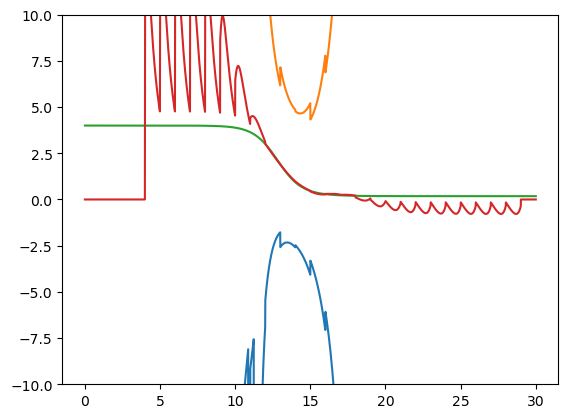

In [157]:
x_min = np.zeros(x.shape)
x_max = np.zeros(x.shape)

for i in range(x.shape[0]):
    x_min[x.shape[0]-1-i] = x2_hat[i,:]-x2_bound[i,:]
    x_max[x.shape[0]-1-i] = x2_hat[i,:]+x2_bound[i,:]

x_min[0] = np.minimum(x_min[0]/x_min[2], x_min[0]/x_max[2])
x_max[0] = np.maximum(x_max[0]/x_min[2], x_max[0]/x_max[2])

plt.plot(integration_time, x_min[0])
plt.plot(integration_time, x_max[0])
plt.plot(integration_time, x[0])
plt.plot(integration_time, x_hat[0])

plt.ylim([-10,10])

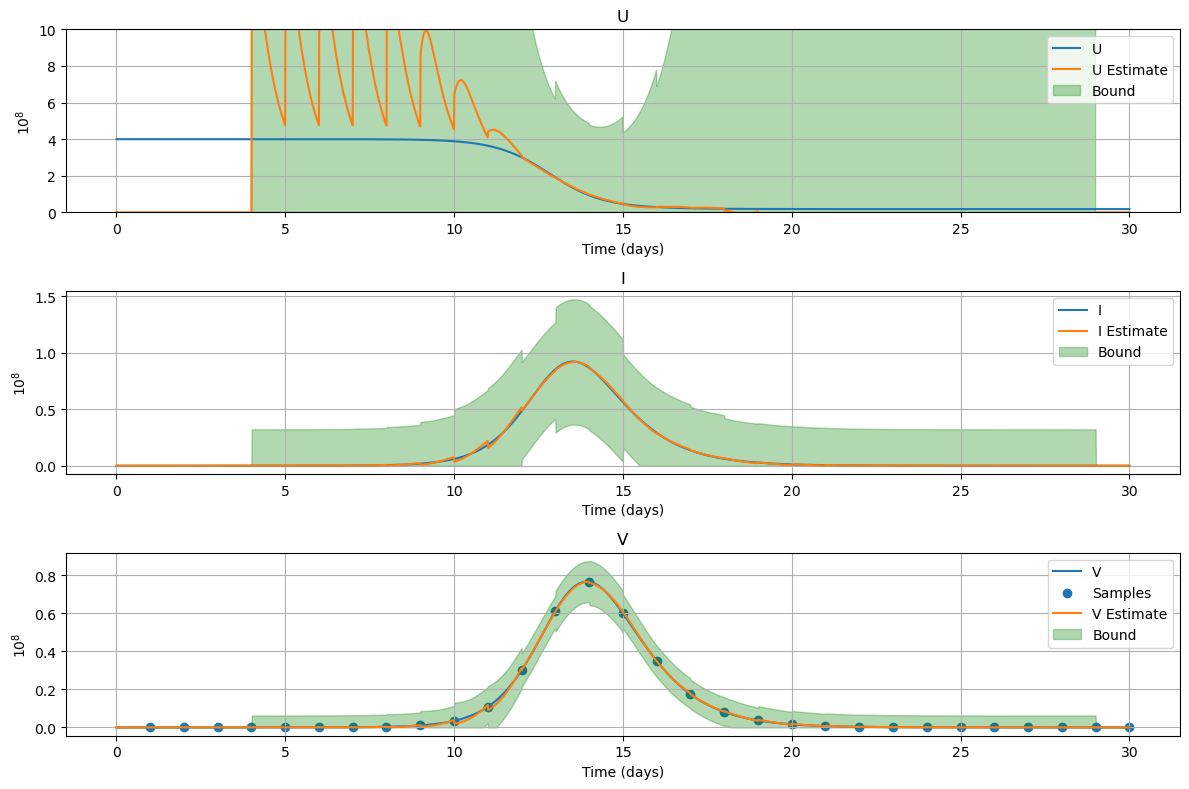

In [164]:
f3 = plt.figure("Transformed State Evolution", figsize=(12,8))
for i in range(n):
    ax = f3.add_subplot(n,1,i+1)
    ax.plot(integration_time, x[i,:], label=states[i])
    # ax.scatter(sampling_time, x2_samples[i,:], label=states2[i]+" at Sample")
    if i==2:
        ax.scatter(sampling_time, x_samples[i,:], label="Samples")
    ax.plot(integration_time, x_hat[i,:], label=states[i]+" Estimate")
    # ax.scatter(sampling_time[N-1:], x2_hat_samples[i, N-1:], label=states2[i]+" Estimate at Sample")
    ax.set_title(states[i])
    ax.set_xlabel("Time (days)")
    ax.set_ylabel("$10^8$")
    if i==0:
        ax.set_ylim([0,10])
    ax.fill_between(integration_time, np.maximum(0, x_min[i]), x_max[i], alpha=0.3, color='green', label='Bound')
    ax.grid()
    ax.legend()
# f3.suptitle(f"beta = {params['beta']}, p={params['p']}, delay={delay}")
f3.tight_layout()

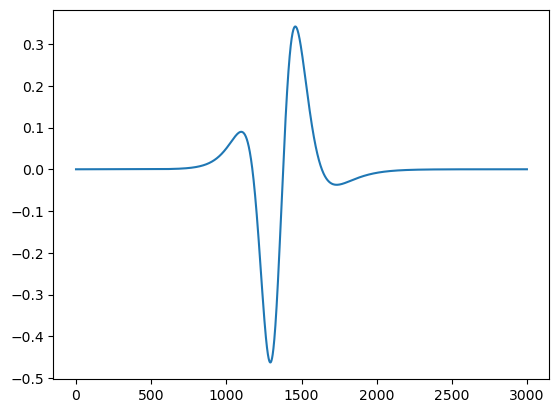

In [142]:
y3 = np.gradient(y_d[2,:], integration_dt)
plt.plot(y3)
plt.show()

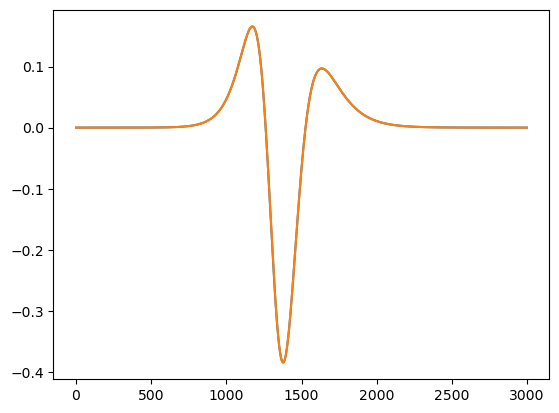

In [143]:
plt.plot(np.gradient(y_d[1,:], integration_dt))
plt.plot(y_d[2,:])
plt.show()

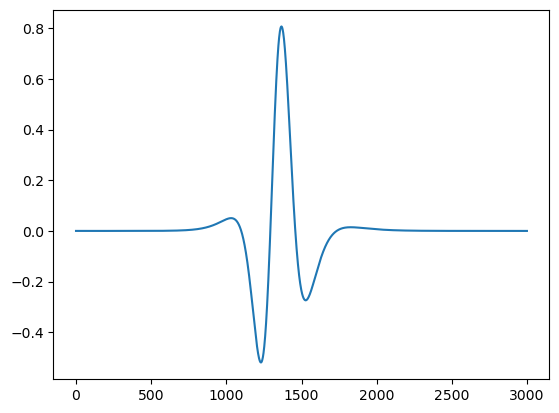

In [144]:
y4 = np.gradient(y3, integration_dt)
plt.plot(y4)
plt.show()

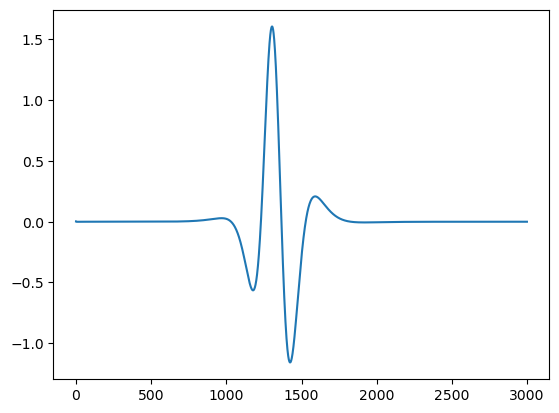

In [145]:
y5 = np.gradient(y4, integration_dt)
plt.plot(y5)
plt.show()

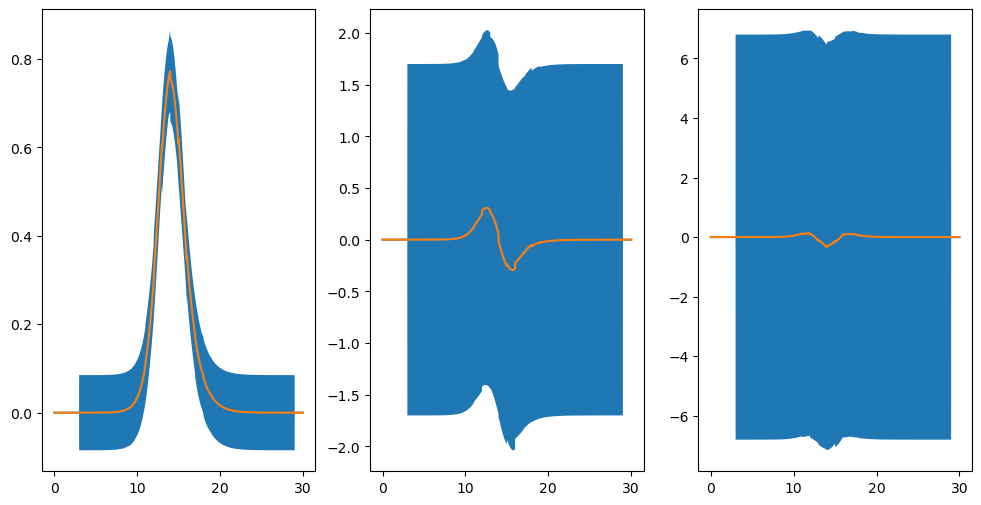

In [146]:
from lib.simulate import simulate
from lib.estimate import get_poly_estimates, get_gauss_estimates

x0= [U0, 0, V0]
d=4

Y_max = [0.8, 0.4, 0.5, 0.5, 0.9, 1.7]

time, x, y_d, t_samples, y_samples = simulate(uiv_ode, x0, integration_dt, sampling_dt, num_sampling_steps)
y_hat1, y_bound1 = get_poly_estimates(t_samples, y_samples, Y_max, N, sampling_dt, d, delay, nderivs, integration_dt)        

plt.figure(figsize=(12,6))
for j in range(uiv_ode.nderivs):
    plt.subplot(1,3,j+1)
    plt.plot(time, y_d[j])
    plt.plot(time, y_hat1[j])
    plt.fill_between(time, (y_hat1-y_bound1)[j], (y_hat1+y_bound1)[j])
plt.show()

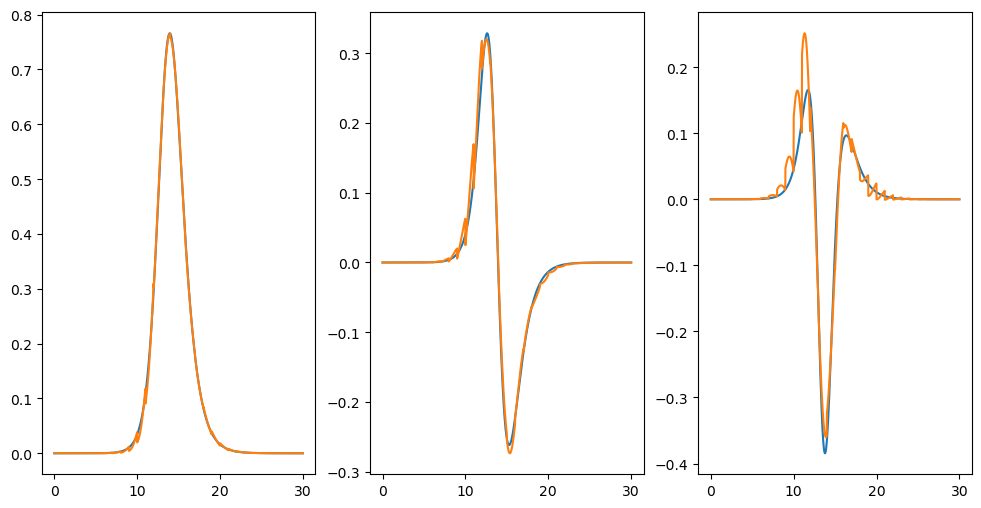

In [147]:
y_hat2, y_bound2 = get_gauss_estimates(t_samples, y_samples, Y_max, N, sampling_dt, n_gauss, delay, nderivs, integration_dt)        

plt.figure(figsize=(12,6))
for j in range(uiv_ode.nderivs):
    plt.subplot(1,3,j+1)
    plt.plot(time, y_d[j])
    plt.plot(time, y_hat2[j])
    plt.fill_between(time, (y_hat2-y_bound2)[j], (y_hat2+y_bound2)[j])
plt.show()